In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import *
from sklearn.preprocessing import StandardScaler

# Single Window Size 60 Minutes

In [12]:
#ticker = "GME"
ticker = "AAPL"

train_import = pd.read_csv("./data_generation/" + ticker + "_min_train.csv")
test_import = pd.read_csv("./data_generation/" + ticker+ "_min_test.csv")

train_dates = pd.to_datetime(train_import['Datetime'])
test_dates = pd.to_datetime(test_import['Datetime'])

train = train_import[["Open", "High", "Low", "Volume", "Close"]]
test = test_import[["Open", "High", "Low", "Volume", "Close"]]

train = train[["Open", "High", "Low", "Volume", "Close"]].astype(float)
test = test[["Open", "High", "Low", "Volume", "Close"]].astype(float)

training_days = train.shape[0]
testing_day = test.shape[0]

FileNotFoundError: [Errno 2] No such file or directory: './data_generation/AAPL_min_train.csv'

In [3]:
#Preprocessing using StandardScaler
scaler1 = StandardScaler().fit(train)
scaler2 = StandardScaler().fit(test)


train_transformed = scaler1.transform(train)
test_transformed = scaler2.transform(test)

#test_transformed = np.array(test)

In [4]:
#Consider past hour of performance to predict the next minute
X_train = []; X_test = []
Y_train = []; Y_test = []

previous_periods = 60; future_periods = 1;
for index in range(previous_periods, len(train) - future_periods + 1):
    if index >= len(train) - previous_periods:
        X_test.append(train_transformed[index - previous_periods : index, 0 : test.shape[1]-1])
        Y_test.append(train_transformed[index + future_periods - 1 : index + future_periods, 4])
    X_train.append(train_transformed[index - previous_periods : index, 0 : train.shape[1]-1])
    Y_train.append(train_transformed[index + future_periods - 1 : index + future_periods, 4]) #3 for index of Close
    
X_train = np.array(X_train)
Y_train = np.array(Y_train)

for index in range(previous_periods, len(test) - future_periods + 1):
    X_test.append(test_transformed[index - previous_periods : index, 0 : test.shape[1]-1])
    Y_test.append(test_transformed[index + future_periods - 1 : index + future_periods, 4]) #3 for index of Close
    
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [5]:
#X_test = np.array(X_test)
#Y_test = np.array(Y_test)

print(X_test.shape)

(524, 60, 4)


In [6]:
#LSTM model for time series forecasting
model = Sequential()
model.add(tf.keras.layers.LSTM(64, input_shape = (X_train.shape[1], X_train.shape[2]), return_sequences = True, activation = 'relu'))
model.add(tf.keras.layers.LSTM(32, return_sequences = False))
model.add(tf.keras.layers.Dense(Y_train.shape[1]))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5)

model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 64)            17664     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 30,113
Trainable params: 30,113
Non-trainable params: 0
_________________________________________________________________


In [7]:
#Train model
history = model.fit(X_train, Y_train, epochs = 20, batch_size = 32, validation_split = 0.2, verbose = 1, callbacks = [early_stopping])

Epoch 1/20
54/54 [==============================] - 1s 27ms/step - loss: 0.0373 - val_loss: 0.1032
Epoch 2/20
54/54 [==============================] - 1s 21ms/step - loss: 0.0047 - val_loss: 0.0748
Epoch 3/20
54/54 [==============================] - 1s 21ms/step - loss: 0.0042 - val_loss: 0.1412
Epoch 4/20
54/54 [==============================] - 1s 21ms/step - loss: 0.0039 - val_loss: 0.3022
Epoch 5/20
54/54 [==============================] - 1s 21ms/step - loss: 0.0037 - val_loss: 0.3574
Epoch 6/20
54/54 [==============================] - 1s 21ms/step - loss: 0.0036 - val_loss: 0.6913
Epoch 7/20
54/54 [==============================] - 1s 21ms/step - loss: 0.0032 - val_loss: 1.2564


In [8]:
prediction = model.predict(X_test)

copy = np.repeat(prediction, train.shape[1], axis = -1)
prediction = scaler2.inverse_transform(copy)[:,0]
print(prediction)

[124.55225  124.57054  124.58677  124.60031  124.6161   124.63649
 124.64681  124.65364  124.66062  124.67272  124.67505  124.67823
 124.67844  124.68239  124.68024  124.67222  124.66628  124.65415
 124.63115  124.620544 124.60303  124.59234  124.584366 124.58614
 124.58978  124.5872   124.58719  124.58292  124.57937  124.591156
 124.587944 124.58256  124.58188  124.5851   124.58341  124.58246
 124.58286  124.584045 124.5805   124.58129  124.5813   124.57922
 124.57718  124.57609  124.576836 124.5708   124.56781  124.56493
 124.57035  124.587944 124.60643  124.61913  124.60539  124.55363
 124.50532  124.45821  124.385895 124.29147  124.21478  124.1669
 124.64973  124.68016  124.719604 124.75976  124.795425 124.83253
 124.8723   124.917114 124.960304 124.99855  125.035515 125.07053
 125.11108  125.148964 125.18861  125.23426  125.28375  125.32667
 125.36832  125.40822  125.44284  125.47097  125.496506 125.519966
 125.55152  125.61182  125.6728   125.73009  125.790726 125.85075
 125.9158

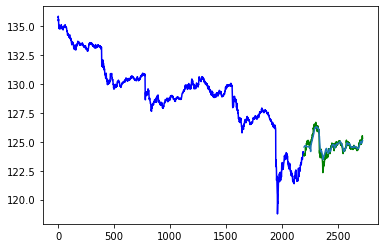

In [9]:
#Overall Forecasting

train_length = train.shape[0]
test_length = test.shape[0]
plt.plot(np.arange(train_length), train[["Close"]], color = 'blue')
plt.plot(np.arange(train_length, train_length + test_length), test[["Close"]], color="green")
plt.plot(np.arange(train_length, train_length + test_length), prediction)
plt.show()

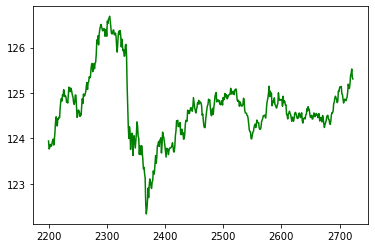

In [10]:
#Forecasting for predicted time period
plt.plot(np.arange(train_length, train_length + test_length), test[["Close"]], color="green")
plt.show()

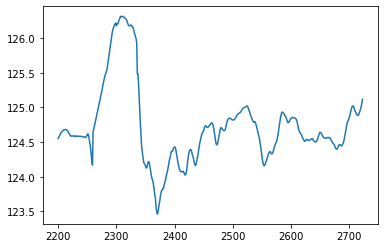

In [11]:
plt.plot(np.arange(train_length, train_length + test_length), prediction)

# Buy/Sell Signals with Moving Averages on Predicted Closing Prices

        Closing  20_Day_SMA  50_Day_SMA  Signal  Position
0    123.600334  123.600334  123.600334       0       NaN
1    123.605843  123.603088  123.603088       0       0.0
2    123.605225  123.603800  123.603800       0       0.0
3    123.607903  123.604826  123.604826       0       0.0
4    123.611137  123.606088  123.606088       0       0.0
..          ...         ...         ...     ...       ...
519  124.918373  124.905021  124.839383       1       0.0
520  124.935669  124.902734  124.855346       1       0.0
521  124.959969  124.905051  124.871004       1       0.0
522  124.989250  124.912287  124.886174       1       0.0
523  125.020454  124.924402  124.900659       1       0.0

[524 rows x 5 columns]


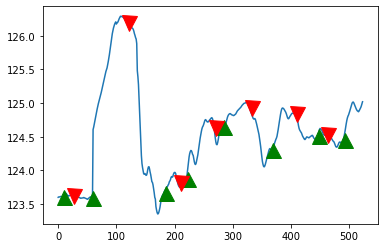

In [16]:
#Code from here: https://towardsdatascience.com/making-a-trade-call-using-simple-moving-average-sma-crossover-strategy-python-implementation-29963326da7a
predicted_closing = pd.DataFrame({"Closing" : prediction})

#Short Term Simple Average 
predicted_closing["20_Day_SMA"] = predicted_closing["Closing"].rolling(window = 10, min_periods=1).mean()
#Long Term Simple Average
predicted_closing["50_Day_SMA"] = predicted_closing["Closing"].rolling(window = 30, min_periods=1).mean()

#Create Position from Signal; +1 is buy, -1 is sell
predicted_closing["Signal"] = np.where(predicted_closing["20_Day_SMA"] > predicted_closing["50_Day_SMA"], 1, 0)
predicted_closing["Position"] = predicted_closing["Signal"].diff()

print(predicted_closing)

#Plot predicted time series
plt.plot(np.arange(0,prediction.shape[0]), prediction)
#Plot buy/sell markers
plt.plot(predicted_closing[predicted_closing["Position"] == 1].index,predicted_closing['20_Day_SMA'][predicted_closing['Position'] == 1], 
         '^', markersize = 15, color = 'g', label = 'buy')
plt.plot(predicted_closing[predicted_closing["Position"] == -1].index,predicted_closing['20_Day_SMA'][predicted_closing['Position'] == -1], 
         'v', markersize = 15, color = 'r', label = 'sell')

plt.show()

          Close  20_Day_SMA  50_Day_SMA  Signal  Position
0    123.945000  123.945000  123.945000       0       NaN
1    123.769997  123.857498  123.857498       0       0.0
2    123.797302  123.837433  123.837433       0       0.0
3    123.870003  123.845575  123.845575       0       0.0
4    123.845001  123.845461  123.845461       0       0.0
..          ...         ...         ...     ...       ...
519  125.389999  125.049220  124.970886       1       0.0
520  125.430000  125.107720  124.992887       1       0.0
521  125.529999  125.177720  125.017216       1       0.0
522  125.339996  125.224220  125.032240       1       0.0
523  125.309998  125.264289  125.044906       1       0.0

[524 rows x 5 columns]


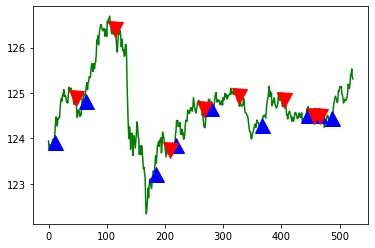

In [17]:
#Buy sell for ground truth
predicted_closing = pd.DataFrame(test[["Close"]])

#Short Term Simple Average 
predicted_closing["20_Day_SMA"] = predicted_closing["Close"].rolling(window = 10, min_periods=1).mean()
#Long Term Simple Average
predicted_closing["50_Day_SMA"] = predicted_closing["Close"].rolling(window = 30, min_periods=1).mean()

#Create Position from Signal; +1 is buy, -1 is sell
predicted_closing["Signal"] = np.where(predicted_closing["20_Day_SMA"] > predicted_closing["50_Day_SMA"], 1, 0)
predicted_closing["Position"] = predicted_closing["Signal"].diff()

print(predicted_closing)

#Plot predicted time series
plt.plot(np.arange(0,prediction.shape[0]), test[["Close"]], "green")
#Plot buy/sell markers
plt.plot(predicted_closing[predicted_closing["Position"] == 1].index,predicted_closing['20_Day_SMA'][predicted_closing['Position'] == 1], 
         '^', markersize = 15, color = 'b', label = 'buy')
plt.plot(predicted_closing[predicted_closing["Position"] == -1].index,predicted_closing['20_Day_SMA'][predicted_closing['Position'] == -1], 
         'v', markersize = 15, color = 'r', label = 'sell')

plt.show()

# Problems Observed

1. Ran on AAPL, results look very close to that of the actual
2. Ran on GME, it could not keep up with the extremely bullish spike trend that happened at the end of 2/24/2021

# Determine what the best window to survey 

Create a for loop to iterate over all window sizes to determine the most optimal one for prediction

In [2]:
#Use Keras to improve upon the bulkiness of the top model
from sklearn.metrics import mean_squared_error 

best_model = None; max_window_size = 60; step = 1; batch_size = 32; min_mse = 100; best_window_size = 1;
ticker = "AAPL"

train_import = pd.read_csv("./data_generation/" + ticker + "_min_train.csv")
test_import = pd.read_csv("./data_generation/" + ticker+ "_min_test.csv")

train_dates = pd.to_datetime(train_import['Datetime'])
test_dates = pd.to_datetime(test_import['Datetime'])

train = train_import[["Open", "High", "Low", "Volume", "Close"]]
test = test_import[["Open", "High", "Low", "Volume", "Close"]]

train = train[["Open", "High", "Low", "Volume", "Close"]].astype(float)
test = test[["Open", "High", "Low", "Volume", "Close"]].astype(float)

training_days = train.shape[0]
testing_day = test.shape[0]

scaler1 = StandardScaler().fit(train)
scaler2 = StandardScaler().fit(test)

train_transformed = scaler1.transform(train)
test_transformed = scaler2.transform(test)

#X_train = train_transformed
#Y_train = train_transformed[:,3]

#print(X_train.shape)
#print(Y_train.shape)

#print(Y_train)

In [3]:
for i in range(10,max_window_size + 1):
    print("Now considering window size: ", i)
    #Consider past minute to hour of performance to predict the next minute
    X_train = []; X_test = []
    Y_train = []; Y_test = []

    previous_periods = i; future_periods = 1;
    for index in range(previous_periods, len(train) - future_periods + 1):
        if index >= len(train) - previous_periods:
            X_test.append(train_transformed[index - previous_periods : index, 0 : train.shape[1]-1])
            Y_test.append(train_transformed[index + future_periods - 1 : index + future_periods, 4])
        X_train.append(train_transformed[index - previous_periods : index, 0 : train.shape[1]-1])
        Y_train.append(train_transformed[index + future_periods - 1 : index + future_periods, 4]) #3 for index of Close
    
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)

    for index in range(previous_periods, len(test) - future_periods + 1):
        X_test.append(test_transformed[index - previous_periods : index, 0 : test.shape[1]-1])
        Y_test.append(test_transformed[index + future_periods - 1 : index + future_periods, 4]) #3 for index of Close
    
    X_test = np.array(X_test)
    Y_test = np.array(Y_test)
    
    #LSTM model for time series forecasting
    model = Sequential()
    model.add(tf.keras.layers.LSTM(64, input_shape = (X_train.shape[1], X_train.shape[2]), return_sequences = True, activation = 'relu'))
    model.add(tf.keras.layers.LSTM(32, return_sequences = False))
    model.add(tf.keras.layers.Dense(Y_train.shape[1]))

    #early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5)

    model.compile(optimizer="adam", loss="mse")
    #model.summary()
    
    #Train model
    history = model.fit(X_train, Y_train, epochs = 10, batch_size = 32, validation_split = 0.2, verbose = 1)#, callbacks = [early_stopping])
    
    compare = mean_squared_error(model.predict(X_test), Y_test)
    print(compare)
    
    if compare < min_mse:
        min_mse = compare
        print("New min MSE is ", min_mse)
        model.save("best_LSTM.h5")
        best_window_size = i
    

Now considering window size:  10
Epoch 1/10
55/55 [==============================] - 2s 14ms/step - loss: 0.1400 - val_loss: 0.0841
Epoch 2/10
55/55 [==============================] - 0s 5ms/step - loss: 0.0035 - val_loss: 0.1015
Epoch 3/10
55/55 [==============================] - 0s 5ms/step - loss: 0.0041 - val_loss: 0.0886
Epoch 4/10
55/55 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.1313
Epoch 5/10
55/55 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.1216
Epoch 6/10
55/55 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.1284
Epoch 7/10
55/55 [==============================] - 0s 5ms/step - loss: 0.0032 - val_loss: 0.1239
Epoch 8/10
55/55 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.1498
Epoch 9/10
55/55 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.1505
Epoch 10/10
55/55 [==============================] - 0s 5ms/step - loss: 0.0025 - va

Epoch 10/10
55/55 [==============================] - 0s 8ms/step - loss: 0.0028 - val_loss: 0.2196
0.09870169659396899
Now considering window size:  18
Epoch 1/10
55/55 [==============================] - 2s 14ms/step - loss: 0.2028 - val_loss: 0.3095
Epoch 2/10
55/55 [==============================] - 0s 8ms/step - loss: 0.0050 - val_loss: 0.2762
Epoch 3/10
55/55 [==============================] - 0s 8ms/step - loss: 0.0042 - val_loss: 0.2608
Epoch 4/10
55/55 [==============================] - 0s 8ms/step - loss: 0.0042 - val_loss: 0.2817
Epoch 5/10
55/55 [==============================] - 0s 8ms/step - loss: 0.0041 - val_loss: 0.2986
Epoch 6/10
55/55 [==============================] - 0s 8ms/step - loss: 0.0042 - val_loss: 0.3529
Epoch 7/10
55/55 [==============================] - 0s 8ms/step - loss: 0.0030 - val_loss: 0.3402
Epoch 8/10
55/55 [==============================] - 0s 8ms/step - loss: 0.0035 - val_loss: 0.3762
Epoch 9/10
55/55 [==============================] - 0s 8ms/step

55/55 [==============================] - 1s 12ms/step - loss: 0.0030 - val_loss: 0.2883
Epoch 9/10
55/55 [==============================] - 1s 12ms/step - loss: 0.0023 - val_loss: 0.1765
Epoch 10/10
55/55 [==============================] - 1s 11ms/step - loss: 0.0026 - val_loss: 0.1880
0.08954529177535277
Now considering window size:  26
Epoch 1/10
55/55 [==============================] - 3s 18ms/step - loss: 0.1697 - val_loss: 0.2482
Epoch 2/10
55/55 [==============================] - 1s 12ms/step - loss: 0.0053 - val_loss: 0.2233
Epoch 3/10
55/55 [==============================] - 1s 12ms/step - loss: 0.0045 - val_loss: 0.2526
Epoch 4/10
55/55 [==============================] - 1s 12ms/step - loss: 0.0041 - val_loss: 0.3983
Epoch 5/10
55/55 [==============================] - 1s 12ms/step - loss: 0.0041 - val_loss: 0.4411
Epoch 6/10
55/55 [==============================] - 1s 12ms/step - loss: 0.0032 - val_loss: 0.4407
Epoch 7/10
55/55 [==============================] - 1s 12ms/step -

54/54 [==============================] - 1s 19ms/step - loss: 0.0040 - val_loss: 0.3303
Epoch 5/10
54/54 [==============================] - 1s 19ms/step - loss: 0.0034 - val_loss: 0.3135
Epoch 6/10
54/54 [==============================] - 1s 19ms/step - loss: 0.0038 - val_loss: 0.4024
Epoch 7/10
54/54 [==============================] - 1s 19ms/step - loss: 0.0032 - val_loss: 0.5068
Epoch 8/10
54/54 [==============================] - 1s 19ms/step - loss: 0.0031 - val_loss: 0.3969
Epoch 9/10
54/54 [==============================] - 1s 19ms/step - loss: 0.0028 - val_loss: 0.3841
Epoch 10/10
54/54 [==============================] - 1s 19ms/step - loss: 0.0028 - val_loss: 0.4026
0.13037325875496492
Now considering window size:  42
Epoch 1/10
54/54 [==============================] - 3s 26ms/step - loss: 0.2025 - val_loss: 0.3163
Epoch 2/10
54/54 [==============================] - 1s 19ms/step - loss: 0.0059 - val_loss: 0.2444
Epoch 3/10
54/54 [==============================] - 1s 19ms/step -

Epoch 2/10
54/54 [==============================] - 1s 23ms/step - loss: 0.0041 - val_loss: 0.2516
Epoch 3/10
54/54 [==============================] - 1s 23ms/step - loss: 0.0039 - val_loss: 0.5526
Epoch 4/10
54/54 [==============================] - 1s 23ms/step - loss: 0.0036 - val_loss: 1.1860
Epoch 5/10
54/54 [==============================] - 1s 24ms/step - loss: 0.0034 - val_loss: 1.0968
Epoch 6/10
54/54 [==============================] - 1s 24ms/step - loss: 0.0028 - val_loss: 1.3034
Epoch 7/10
54/54 [==============================] - 1s 23ms/step - loss: 0.0029 - val_loss: 1.4340
Epoch 8/10
54/54 [==============================] - 1s 23ms/step - loss: 0.0029 - val_loss: 1.3995
Epoch 9/10
54/54 [==============================] - 1s 23ms/step - loss: 0.0023 - val_loss: 1.4523
Epoch 10/10
54/54 [==============================] - 1s 23ms/step - loss: 0.0026 - val_loss: 1.4849
0.1971229327682939
Now considering window size:  50
Epoch 1/10
54/54 [==============================] - 3s 2

0.12111220595686895
Now considering window size:  57
Epoch 1/10
54/54 [==============================] - 3s 34ms/step - loss: 0.1394 - val_loss: 0.1066
Epoch 2/10
54/54 [==============================] - 2s 28ms/step - loss: 0.0052 - val_loss: 0.2079
Epoch 3/10
54/54 [==============================] - 2s 28ms/step - loss: 0.0044 - val_loss: 0.3926
Epoch 4/10
54/54 [==============================] - 2s 28ms/step - loss: 0.0036 - val_loss: 0.5803
Epoch 5/10
54/54 [==============================] - 1s 28ms/step - loss: 0.0038 - val_loss: 0.7188
Epoch 6/10
54/54 [==============================] - 1s 28ms/step - loss: 0.0032 - val_loss: 1.2523
Epoch 7/10
54/54 [==============================] - 2s 28ms/step - loss: 0.0028 - val_loss: 0.7591
Epoch 8/10
54/54 [==============================] - 2s 28ms/step - loss: 0.0027 - val_loss: 0.6917
Epoch 9/10
54/54 [==============================] - 2s 28ms/step - loss: 0.0029 - val_loss: 0.6744
Epoch 10/10
54/54 [==============================] - 2s 

In [4]:
#Use best model for prediction
print("The best window size is: ", best_window_size)
best_model = tf.keras.models.load_model("best_LSTM_window.h5")

prediction = best_model.predict(X_test)

copy = np.repeat(prediction, train.shape[1], axis = -1)
prediction = scaler2.inverse_transform(copy)[:,0]
print(prediction)

The best window size is:  47
[123.30662  123.31083  123.311165 123.313614 123.31879  123.32369
 123.31621  123.30796  123.3077   123.33659  123.36135  123.39026
 123.411865 123.41992  123.42355  123.39426  123.381424 123.3747
 123.372154 123.38884  123.40394  123.415596 123.4205   123.41936
 123.41948  123.42692  123.43038  123.43229  123.433586 123.44906
 123.45861  123.46478  123.4702   123.47627  123.47978  123.4817
 123.4819   123.48568  123.484955 123.49431  123.50578  123.51357
 123.52089  123.53186  123.54351  123.54229  123.54169  123.54272
 123.54336  123.54532  123.54876  123.55826  123.57624  123.586525
 123.596466 123.60431  123.602974 123.600266 123.6002   123.5935
 124.64574  124.704865 124.76789  124.8235   124.867355 124.91113
 124.95712  125.009254 125.05096  125.08712  125.122925 125.15738
 125.19461  125.22886  125.26818  125.3173   125.37079  125.40583
 125.4421   125.47873  125.504295 125.52769  125.55228  125.580696
 125.62908  125.70872  125.78623  125.84328  125

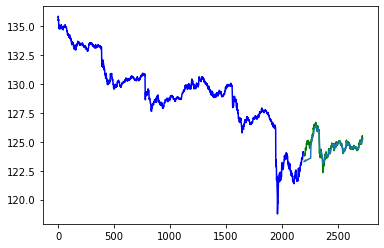

In [5]:
#Overall Forecasting
train_length = train.shape[0]
test_length = test.shape[0]
plt.plot(np.arange(train_length), train[["Close"]], color = 'blue')
plt.plot(np.arange(train_length, train_length + test_length), test[["Close"]], color="green")
plt.plot(np.arange(train_length, train_length + test_length), prediction)
plt.show()

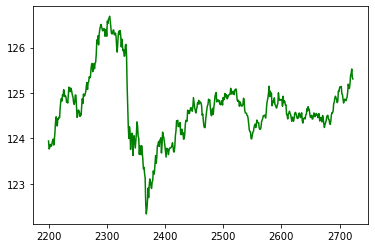

In [7]:
#Forecasting for predicted time period
plt.plot(np.arange(train_length, train_length + test_length), test[["Close"]], color="green")
plt.show()

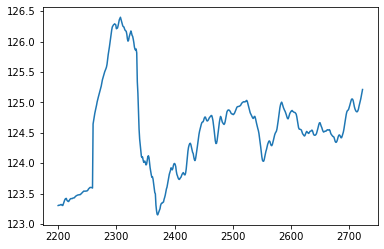

In [8]:
plt.plot(np.arange(train_length, train_length + test_length), prediction)

# Training LSTM on all S&P 500 daily stock data

In [29]:
list_of_tickers = ['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADBE', 'AMD', 'AAP', 'AES', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALXN', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'AAPL', 'AMAT', 'APTV', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'BKR', 'BLL', 'BAC', 'BK', 'BAX', 'BDX', 'BRK.B', 'BBY', 'BIO', 'BIIB', 'BLK', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BF.B', 'CHRW', 'COG', 'CDNS', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'CNC', 'CNP', 'CERN', 'CF', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CTXS', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'COO', 'CPRT', 'GLW', 'CTVA', 'COST', 'CCI', 'CSX', 'CMI', 'CVS', 'DHI', 'DHR', 'DRI', 'DVA', 'DE', 'DAL', 'XRAY', 'DVN', 'DXCM', 'FANG', 'DLR', 'DFS', 'DISCA', 'DISCK', 'DISH', 'DG', 'DLTR', 'D', 'DPZ', 'DOV', 'DOW', 'DTE', 'DUK', 'DRE', 'DD', 'DXC', 'EMN', 'ETN', 'EBAY', 'ECL', 'EIX', 'EW', 'EA', 'EMR', 'ENPH', 'ETR', 'EOG', 'EFX', 'EQIX', 'EQR', 'ESS', 'EL', 'ETSY', 'EVRG', 'ES', 'RE', 'EXC', 'EXPE', 'EXPD', 'EXR', 'XOM', 'FFIV', 'FB', 'FAST', 'FRT', 'FDX', 'FIS', 'FITB', 'FE', 'FRC', 'FISV', 'FLT', 'FLIR', 'FLS', 'FMC', 'F', 'FTNT', 'FTV', 'FBHS', 'FOXA', 'FOX', 'BEN', 'FCX', 'GPS', 'GRMN', 'IT', 'GD', 'GE', 'GIS', 'GM', 'GPC', 'GILD', 'GL', 'GPN', 'GS', 'GWW', 'HAL', 'HBI', 'HIG', 'HAS', 'HCA', 'PEAK', 'HSIC', 'HSY', 'HES', 'HPE', 'HLT', 'HFC', 'HOLX', 'HD', 'HON', 'HRL', 'HST', 'HWM', 'HPQ', 'HUM', 'HBAN', 'HII', 'IEX', 'IDXX', 'INFO', 'ITW', 'ILMN', 'INCY', 'IR', 'INTC', 'ICE', 'IBM', 'IP', 'IPG', 'IFF', 'INTU', 'ISRG', 'IVZ', 'IPGP', 'IQV', 'IRM', 'JKHY', 'J', 'JBHT', 'SJM', 'JNJ', 'JCI', 'JPM', 'JNPR', 'KSU', 'K', 'KEY', 'KEYS', 'KMB', 'KIM', 'KMI', 'KLAC', 'KHC', 'KR', 'LB', 'LHX', 'LH', 'LRCX', 'LW', 'LVS', 'LEG', 'LDOS', 'LEN', 'LLY', 'LNC', 'LIN', 'LYV', 'LKQ', 'LMT', 'L', 'LOW', 'LUMN', 'LYB', 'MTB', 'MRO', 'MPC', 'MKTX', 'MAR', 'MMC', 'MLM', 'MAS', 'MA', 'MKC', 'MXIM', 'MCD', 'MCK', 'MDT', 'MRK', 'MET', 'MTD', 'MGM', 'MCHP', 'MU', 'MSFT', 'MAA', 'MHK', 'TAP', 'MDLZ', 'MPWR', 'MNST', 'MCO', 'MS', 'MOS', 'MSI', 'MSCI', 'NDAQ', 'NTAP', 'NFLX', 'NWL', 'NEM', 'NWSA', 'NWS', 'NEE', 'NLSN', 'NKE', 'NI', 'NSC', 'NTRS', 'NOC', 'NLOK', 'NCLH', 'NOV', 'NRG', 'NUE', 'NVDA', 'NVR', 'ORLY', 'OXY', 'ODFL', 'OMC', 'OKE', 'ORCL', 'OTIS', 'PCAR', 'PKG', 'PH', 'PAYX', 'PAYC', 'PYPL', 'PNR', 'PBCT', 'PEP', 'PKI', 'PRGO', 'PFE', 'PM', 'PSX', 'PNW', 'PXD', 'PNC', 'POOL', 'PPG', 'PPL', 'PFG', 'PG', 'PGR', 'PLD', 'PRU', 'PEG', 'PSA', 'PHM', 'PVH', 'QRVO', 'PWR', 'QCOM', 'DGX', 'RL', 'RJF', 'RTX', 'O', 'REG', 'REGN', 'RF', 'RSG', 'RMD', 'RHI', 'ROK', 'ROL', 'ROP', 'ROST', 'RCL', 'SPGI', 'CRM', 'SBAC', 'SLB', 'STX', 'SEE', 'SRE', 'NOW', 'SHW', 'SPG', 'SWKS', 'SLG', 'SNA', 'SO', 'LUV', 'SWK', 'SBUX', 'STT', 'STE', 'SYK', 'SIVB', 'SYF', 'SNPS', 'SYY', 'TMUS', 'TROW', 'TTWO', 'TPR', 'TGT', 'TEL', 'TDY', 'TFX', 'TER', 'TSLA', 'TXN', 'TXT', 'TMO', 'TJX', 'TSCO', 'TT', 'TDG', 'TRV', 'TRMB', 'TFC', 'TWTR', 'TYL', 'TSN', 'UDR', 'ULTA', 'USB', 'UAA', 'UA', 'UNP', 'UAL', 'UNH', 'UPS', 'URI', 'UHS', 'UNM', 'VLO', 'VAR', 'VTR', 'VRSN', 'VRSK', 'VZ', 'VRTX', 'VFC', 'VIAC', 'VTRS', 'V', 'VNT', 'VNO', 'VMC', 'WRB', 'WAB', 'WMT', 'WBA', 'DIS', 'WM', 'WAT', 'WEC', 'WFC', 'WELL', 'WST', 'WDC', 'WU', 'WRK', 'WY', 'WHR', 'WMB', 'WLTW', 'WYNN', 'XEL', 'XRX', 'XLNX', 'XYL', 'YUM', 'ZBRA', 'ZBH', 'ZION', 'ZTS']
list_of_tickers.remove("BRK.B")
list_of_tickers.remove("BF.B")

total_df = pd.read_csv("./data_generation/Stock_data/Daily_data_MMM.csv")

#total_train = 
#total_test 

for ticker in list_of_tickers:
    if ticker == "MMM":
        continue
    else:
        added_df = pd.read_csv("./data_generation/Stock_data/Daily_data_" + ticker + ".csv")
        total_df = pd.concat([total_df, added_df])

In [31]:
total_df = total_df[["High", "Low", "Open", "Volume", "Close"]]

scaler = StandardScaler().fit(total_df)
total_df_transformed = scaler.transform(total_df)

print(total_df_transformed)

ValueError: could not convert string to float: 'High'

In [24]:
X_train = []; Y_train = []

previous_periods = 7; future_periods = 1;
for index in range(previous_periods, len(total_df) - future_periods + 1):
    X_train.append(total_df_transformed[index - previous_periods : index, 0 : total_df.shape[1]-1])
    Y_train.append(total_df_transformed[index + future_periods - 1 : index + future_periods, 4]) #3 for index of Close
    
X_train = np.array(X_train)
Y_train = np.array(Y_train)

print(X_train.shape)

(2394037, 7, 4)


In [25]:
#LSTM model for time series forecasting
model = Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape = (X_train.shape[1], X_train.shape[2]), return_sequences = True, activation = 'relu'))
model.add(tf.keras.layers.LSTM(64, return_sequences = False)) # Changed from 64
model.add(tf.keras.layers.Dense(Y_train.shape[1]))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5)

lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-4,
    decay_steps=10000,
    decay_rate=0.9)
Adam = tf.keras.optimizers.Adam(learning_rate = lr)

model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 7, 128)            68096     
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 199,809
Trainable params: 199,809
Non-trainable params: 0
_________________________________________________________________


In [26]:
#Train model
history = model.fit(X_train, Y_train, epochs = 5, batch_size = 32, validation_split = 0.2, verbose = 1, callbacks = [early_stopping])

Epoch 1/5
59851/59851 [==============================] - 402s 7ms/step - loss: 0.0124 - val_loss: 8.0857e-04
Epoch 2/5
59851/59851 [==============================] - 396s 7ms/step - loss: 0.0098 - val_loss: 0.0010
Epoch 3/5
59851/59851 [==============================] - 387s 6ms/step - loss: 0.0075 - val_loss: 8.8445e-04
Epoch 4/5
59851/59851 [==============================] - 395s 7ms/step - loss: 0.0051 - val_loss: 7.2143e-04
Epoch 5/5
59851/59851 [==============================] - 392s 7ms/step - loss: 0.0050 - val_loss: 8.1038e-04


## Save model

In [17]:
model.save("./models/S&P500_model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/S&P500_model\assets


## Testing the Large LSTM

In [18]:
#Load the model
model = tf.keras.models.load_model("./models/S&P500_model")

In [17]:
#Predict the AAPL test data
prediction = model.predict(X_test)

copy = np.repeat(prediction, train.shape[1], axis = -1)
prediction = scaler2.inverse_transform(copy)[:,0]
print(prediction)

[123.84798  122.14993  124.1505   123.93159  123.41359  123.40395
 123.54784  122.26897  123.42635  122.471825 123.67483  123.944824
 121.2395   122.062325 124.21717  124.717125 123.01591  121.481384
 121.94307  123.072945 121.705376 120.27541  123.4684   124.15422
 124.5213   123.2533   123.42586  122.7428   122.24188  123.42368
 122.54193  124.56898  124.407974 122.35929  119.859604 119.97268
 122.896286 122.18448  124.41975  124.554405 123.93132  121.771736
 126.38882  122.24548  123.90097  124.59539  124.70426  122.00648
 122.0728   122.079994 122.48554  122.468666 123.44155  127.09457
 122.18062  122.080444 123.165855 119.60187  122.77504  124.50752
 123.995705 126.44556  122.00293  125.38193  124.90371  124.13713
 124.80257  125.894356 123.30873  121.60886  124.54701  125.26015
 125.56926  124.746155 124.84511  124.68939  124.65909  123.86552
 124.807365 125.844635 127.67013  126.127686 126.36683  125.965706
 125.38443  123.571045 123.73579  124.63431  126.04552  125.88505
 125.7

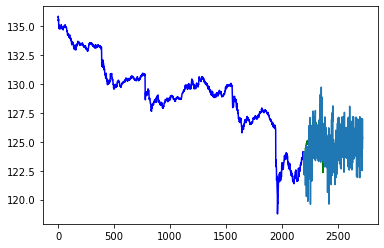

In [18]:
#Overall Forecasting

train_length = train.shape[0]
test_length = test.shape[0]
plt.plot(np.arange(train_length), train[["Close"]], color = 'blue')
plt.plot(np.arange(train_length, train_length + test_length), test[["Close"]], color="green")
plt.plot(np.arange(train_length, train_length + test_length), prediction)
plt.show()

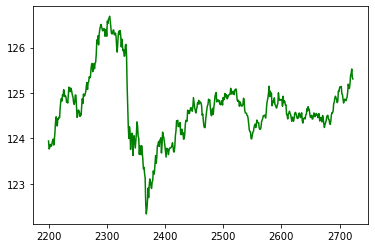

In [19]:
#Forecasting for predicted time period
plt.plot(np.arange(train_length, train_length + test_length), test[["Close"]], color="green")
plt.show()

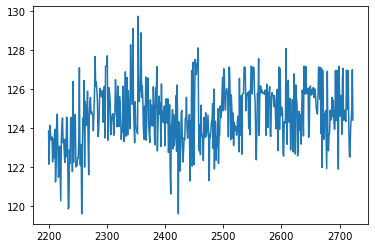

In [20]:
plt.plot(np.arange(train_length, train_length + test_length), prediction)

        Closing  20_Day_SMA  50_Day_SMA  Signal  Position
0    123.847977  123.847977  123.847977       0       NaN
1    122.149933  122.998955  122.998955       0       0.0
2    124.150497  123.382802  123.382802       0       0.0
3    123.931587  123.519999  123.519999       0       0.0
4    123.413589  123.498717  123.498717       0       0.0
..          ...         ...         ...     ...       ...
519  123.940315  124.753733  124.934083       0       0.0
520  124.405876  124.754465  124.927219       0       0.0
521  124.905006  124.810430  124.959155       0       0.0
522  126.991692  124.811755  125.060551       0       0.0
523  124.413475  124.756991  124.975771       0       0.0

[524 rows x 5 columns]


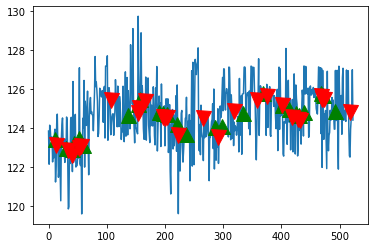

In [21]:
#Code from here: https://towardsdatascience.com/making-a-trade-call-using-simple-moving-average-sma-crossover-strategy-python-implementation-29963326da7a
predicted_closing = pd.DataFrame({"Closing" : prediction})

#Short Term Simple Average 
predicted_closing["20_Day_SMA"] = predicted_closing["Closing"].rolling(window = 10, min_periods=1).mean()
#Long Term Simple Average
predicted_closing["50_Day_SMA"] = predicted_closing["Closing"].rolling(window = 30, min_periods=1).mean()

#Create Position from Signal; +1 is buy, -1 is sell
predicted_closing["Signal"] = np.where(predicted_closing["20_Day_SMA"] > predicted_closing["50_Day_SMA"], 1, 0)
predicted_closing["Position"] = predicted_closing["Signal"].diff()

print(predicted_closing)

#Plot predicted time series
plt.plot(np.arange(0,prediction.shape[0]), prediction)
#Plot buy/sell markers
plt.plot(predicted_closing[predicted_closing["Position"] == 1].index,predicted_closing['20_Day_SMA'][predicted_closing['Position'] == 1], 
         '^', markersize = 15, color = 'g', label = 'buy')
plt.plot(predicted_closing[predicted_closing["Position"] == -1].index,predicted_closing['20_Day_SMA'][predicted_closing['Position'] == -1], 
         'v', markersize = 15, color = 'r', label = 'sell')

plt.show()

# LSTM for Multi-Step Prediction

In [2]:
list_of_tickers = ['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADBE', 'AMD', 'AAP', 'AES', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALXN', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'AAPL', 'AMAT', 'APTV', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'BKR', 'BLL', 'BAC', 'BK', 'BAX', 'BDX', 'BRK.B', 'BBY', 'BIO', 'BIIB', 'BLK', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BF.B', 'CHRW', 'COG', 'CDNS', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'CNC', 'CNP', 'CERN', 'CF', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CTXS', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'COO', 'CPRT', 'GLW', 'CTVA', 'COST', 'CCI', 'CSX', 'CMI', 'CVS', 'DHI', 'DHR', 'DRI', 'DVA', 'DE', 'DAL', 'XRAY', 'DVN', 'DXCM', 'FANG', 'DLR', 'DFS', 'DISCA', 'DISCK', 'DISH', 'DG', 'DLTR', 'D', 'DPZ', 'DOV', 'DOW', 'DTE', 'DUK', 'DRE', 'DD', 'DXC', 'EMN', 'ETN', 'EBAY', 'ECL', 'EIX', 'EW', 'EA', 'EMR', 'ENPH', 'ETR', 'EOG', 'EFX', 'EQIX', 'EQR', 'ESS', 'EL', 'ETSY', 'EVRG', 'ES', 'RE', 'EXC', 'EXPE', 'EXPD', 'EXR', 'XOM', 'FFIV', 'FB', 'FAST', 'FRT', 'FDX', 'FIS', 'FITB', 'FE', 'FRC', 'FISV', 'FLT', 'FLIR', 'FLS', 'FMC', 'F', 'FTNT', 'FTV', 'FBHS', 'FOXA', 'FOX', 'BEN', 'FCX', 'GPS', 'GRMN', 'IT', 'GD', 'GE', 'GIS', 'GM', 'GPC', 'GILD', 'GL', 'GPN', 'GS', 'GWW', 'HAL', 'HBI', 'HIG', 'HAS', 'HCA', 'PEAK', 'HSIC', 'HSY', 'HES', 'HPE', 'HLT', 'HFC', 'HOLX', 'HD', 'HON', 'HRL', 'HST', 'HWM', 'HPQ', 'HUM', 'HBAN', 'HII', 'IEX', 'IDXX', 'INFO', 'ITW', 'ILMN', 'INCY', 'IR', 'INTC', 'ICE', 'IBM', 'IP', 'IPG', 'IFF', 'INTU', 'ISRG', 'IVZ', 'IPGP', 'IQV', 'IRM', 'JKHY', 'J', 'JBHT', 'SJM', 'JNJ', 'JCI', 'JPM', 'JNPR', 'KSU', 'K', 'KEY', 'KEYS', 'KMB', 'KIM', 'KMI', 'KLAC', 'KHC', 'KR', 'LB', 'LHX', 'LH', 'LRCX', 'LW', 'LVS', 'LEG', 'LDOS', 'LEN', 'LLY', 'LNC', 'LIN', 'LYV', 'LKQ', 'LMT', 'L', 'LOW', 'LUMN', 'LYB', 'MTB', 'MRO', 'MPC', 'MKTX', 'MAR', 'MMC', 'MLM', 'MAS', 'MA', 'MKC', 'MXIM', 'MCD', 'MCK', 'MDT', 'MRK', 'MET', 'MTD', 'MGM', 'MCHP', 'MU', 'MSFT', 'MAA', 'MHK', 'TAP', 'MDLZ', 'MPWR', 'MNST', 'MCO', 'MS', 'MOS', 'MSI', 'MSCI', 'NDAQ', 'NTAP', 'NFLX', 'NWL', 'NEM', 'NWSA', 'NWS', 'NEE', 'NLSN', 'NKE', 'NI', 'NSC', 'NTRS', 'NOC', 'NLOK', 'NCLH', 'NOV', 'NRG', 'NUE', 'NVDA', 'NVR', 'ORLY', 'OXY', 'ODFL', 'OMC', 'OKE', 'ORCL', 'OTIS', 'PCAR', 'PKG', 'PH', 'PAYX', 'PAYC', 'PYPL', 'PNR', 'PBCT', 'PEP', 'PKI', 'PRGO', 'PFE', 'PM', 'PSX', 'PNW', 'PXD', 'PNC', 'POOL', 'PPG', 'PPL', 'PFG', 'PG', 'PGR', 'PLD', 'PRU', 'PEG', 'PSA', 'PHM', 'PVH', 'QRVO', 'PWR', 'QCOM', 'DGX', 'RL', 'RJF', 'RTX', 'O', 'REG', 'REGN', 'RF', 'RSG', 'RMD', 'RHI', 'ROK', 'ROL', 'ROP', 'ROST', 'RCL', 'SPGI', 'CRM', 'SBAC', 'SLB', 'STX', 'SEE', 'SRE', 'NOW', 'SHW', 'SPG', 'SWKS', 'SLG', 'SNA', 'SO', 'LUV', 'SWK', 'SBUX', 'STT', 'STE', 'SYK', 'SIVB', 'SYF', 'SNPS', 'SYY', 'TMUS', 'TROW', 'TTWO', 'TPR', 'TGT', 'TEL', 'TDY', 'TFX', 'TER', 'TSLA', 'TXN', 'TXT', 'TMO', 'TJX', 'TSCO', 'TT', 'TDG', 'TRV', 'TRMB', 'TFC', 'TWTR', 'TYL', 'TSN', 'UDR', 'ULTA', 'USB', 'UAA', 'UA', 'UNP', 'UAL', 'UNH', 'UPS', 'URI', 'UHS', 'UNM', 'VLO', 'VAR', 'VTR', 'VRSN', 'VRSK', 'VZ', 'VRTX', 'VFC', 'VIAC', 'VTRS', 'V', 'VNT', 'VNO', 'VMC', 'WRB', 'WAB', 'WMT', 'WBA', 'DIS', 'WM', 'WAT', 'WEC', 'WFC', 'WELL', 'WST', 'WDC', 'WU', 'WRK', 'WY', 'WHR', 'WMB', 'WLTW', 'WYNN', 'XEL', 'XRX', 'XLNX', 'XYL', 'YUM', 'ZBRA', 'ZBH', 'ZION', 'ZTS']
list_of_tickers.remove("BRK.B")
list_of_tickers.remove("BF.B")

total_df = pd.read_csv("./data_generation/Stock_data/Daily_data_MMM.csv")

#total_train = 
#total_test 

for ticker in list_of_tickers:
    if ticker == "MMM":
        continue
    else:
        added_df = pd.read_csv("./data_generation/Stock_data/Daily_data_" + ticker + ".csv")
        total_df = pd.concat([total_df, added_df])

In [3]:
temp_total_df = total_df

In [4]:
total_df = temp_total_df

In [5]:
from scipy.stats import zscore
print(total_df.head(1))
total_df = total_df[["High", "Low", "Open", "Volume", "Close"]].reset_index(drop=True)
total_df = total_df[total_df.High != "High"]
print(total_df)

scaler = StandardScaler().fit(total_df)
total_df_transformed = scaler.transform(total_df)

print(total_df_transformed)

         Date   High       Low      Open    Close     Volume  \
0  2000-01-03  48.25  47.03125  48.03125  47.1875  2173400.0   

            Adj Close  
0  27.588531494140625  
             High       Low      Open      Volume    Close
0           48.25  47.03125  48.03125   2173400.0  47.1875
1        47.40625   45.3125   46.4375   2713800.0  45.3125
2          48.125   45.5625   45.5625   3699400.0   46.625
3           51.25  47.15625  47.15625   5975800.0   50.375
4        51.90625  49.96875   50.5625   4101200.0   51.375
...           ...       ...       ...         ...      ...
2394927     149.6    145.02    148.01  2.3031e+06   145.15
2394928    153.49    147.35     147.5  3.1215e+06   150.14
2394929     152.7    148.57    150.45  2.1192e+06   151.09
2394930    153.55    152.19    152.66  1.4568e+06   152.36
2394931   152.852    150.69     152.2      549339   152.52

[2394821 rows x 5 columns]
[[-0.13921365 -0.14003961 -0.13668102 -0.1233117  -0.14323969]
 [-0.14563862 -0.1534471

## Close Model

In [7]:
X_train = []; Y_train = []

previous_periods = 7; future_periods = 1;
for index in range(previous_periods, len(total_df) - future_periods + 1):
    X_train.append(total_df_transformed[index - previous_periods : index,0 : 5])#total_df.shape[1]-1])
    Y_train.append(total_df_transformed[index + future_periods - 1 : index + future_periods, 4]) 
    
X_train = np.array(X_train)
Y_train = np.array(Y_train)

#X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

print(X_train.shape)
print(Y_train.shape)

(2394814, 7, 5)
(2394814, 1)


In [12]:
#LSTM model for time series forecasting
model = Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape = (X_train.shape[1], 5), return_sequences = True, activation = 'relu'))
model.add(tf.keras.layers.LSTM(64, return_sequences = False)) # Changed from 64
model.add(tf.keras.layers.Dense(Y_train.shape[1]))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 3)

lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-4,
    decay_steps=10000,
    decay_rate=0.9)
Adam = tf.keras.optimizers.Adam(learning_rate = lr)

model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 7, 128)            68608     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 118,081
Trainable params: 118,081
Non-trainable params: 0
_________________________________________________________________


In [13]:
#Train model
with tf.device('/GPU:0'):
    history = model.fit(X_train, Y_train, epochs = 5, batch_size = 32, validation_split = 0.2, verbose = 1, callbacks = [early_stopping])

Epoch 1/5
59871/59871 [==============================] - 382s 6ms/step - loss: 0.0358 - val_loss: 6.8544e-04
Epoch 2/5
59871/59871 [==============================] - 374s 6ms/step - loss: 0.0034 - val_loss: 8.2151e-04
Epoch 3/5
59871/59871 [==============================] - 395s 7ms/step - loss: 0.0090 - val_loss: 7.1776e-04
Epoch 4/5
59871/59871 [==============================] - 393s 7ms/step - loss: 0.0162 - val_loss: 8.7361e-04


In [14]:
model.save("./models/close_model_2")

INFO:tensorflow:Assets written to: ./models/close_model_2\assets


INFO:tensorflow:Assets written to: ./models/close_model_2\assets


## Volume Model

In [15]:
X_train = []; Y_train = []

previous_periods = 7; future_periods = 1;
for index in range(previous_periods, len(total_df) - future_periods + 1):
    X_train.append(total_df_transformed[index - previous_periods : index, 0:5])#[0,1,2,4]])
    Y_train.append(total_df_transformed[index + future_periods - 1 : index + future_periods, 3]) 
    
X_train = np.array(X_train)
Y_train = np.array(Y_train)

#X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

print(X_train.shape)
print(Y_train.shape)

(2394814, 7, 5)
(2394814, 1)


In [16]:
model = Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape = (X_train.shape[1], 5), return_sequences = True, activation = 'relu'))
model.add(tf.keras.layers.LSTM(64, return_sequences = False)) # Changed from 64
model.add(tf.keras.layers.Dense(Y_train.shape[1]))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 3)

lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-4,
    decay_steps=10000,
    decay_rate=0.9)
Adam = tf.keras.optimizers.Adam(learning_rate = lr)

model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 7, 128)            68608     
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 118,081
Trainable params: 118,081
Non-trainable params: 0
_________________________________________________________________


In [17]:
#Train model
with tf.device('/GPU:0'):
    history = model.fit(X_train, Y_train, epochs = 5, batch_size = 32, validation_split = 0.2, verbose = 1, callbacks = [early_stopping])

Epoch 1/5
59871/59871 [==============================] - 383s 6ms/step - loss: 0.3589 - val_loss: 0.0149
Epoch 2/5
59871/59871 [==============================] - 395s 7ms/step - loss: 0.2191 - val_loss: 0.0190
Epoch 3/5
59871/59871 [==============================] - 416s 7ms/step - loss: 0.1993 - val_loss: 0.0149
Epoch 4/5
59871/59871 [==============================] - 426s 7ms/step - loss: 0.2064 - val_loss: 0.0151


In [18]:
model.save("./models/volume_model_2")

INFO:tensorflow:Assets written to: ./models/volume_model_2\assets


INFO:tensorflow:Assets written to: ./models/volume_model_2\assets


## Open Model

In [19]:
X_train = []; Y_train = []

previous_periods = 7; future_periods = 1;
for index in range(previous_periods, len(total_df) - future_periods + 1):
    X_train.append(total_df_transformed[index - previous_periods : index, 0:5])#[0,1,3,4]])
    Y_train.append(total_df_transformed[index + future_periods - 1 : index + future_periods, 2]) 
    
X_train = np.array(X_train)
Y_train = np.array(Y_train)

#X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

print(X_train.shape)
print(Y_train.shape)

(2394814, 7, 5)
(2394814, 1)


In [20]:
model = Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape = (X_train.shape[1], 5), return_sequences = True, activation = 'relu'))
model.add(tf.keras.layers.LSTM(64, return_sequences = False)) # Changed from 64
model.add(tf.keras.layers.Dense(Y_train.shape[1]))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 3)

lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-4,
    decay_steps=10000,
    decay_rate=0.9)
Adam = tf.keras.optimizers.Adam(learning_rate = lr)

model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 7, 128)            68608     
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 118,081
Trainable params: 118,081
Non-trainable params: 0
_________________________________________________________________


In [21]:
#Train model
with tf.device('/GPU:0'):
    history = model.fit(X_train, Y_train, epochs = 5, batch_size = 32, validation_split = 0.2, verbose = 1, callbacks = [early_stopping])

Epoch 1/5
59871/59871 [==============================] - 521s 9ms/step - loss: 0.0395 - val_loss: 6.3231e-04
Epoch 2/5
59871/59871 [==============================] - 579s 10ms/step - loss: 0.0041 - val_loss: 5.6252e-04
Epoch 3/5
59871/59871 [==============================] - 560s 9ms/step - loss: 0.0059 - val_loss: 5.7954e-04
Epoch 4/5
59871/59871 [==============================] - 559s 9ms/step - loss: 0.0115 - val_loss: 5.7404e-04
Epoch 5/5
59871/59871 [==============================] - 542s 9ms/step - loss: 0.0199 - val_loss: 6.3168e-04


In [22]:
model.save("./models/open_model_2")

INFO:tensorflow:Assets written to: ./models/open_model_2\assets


INFO:tensorflow:Assets written to: ./models/open_model_2\assets


## Low Model

In [23]:
X_train = []; Y_train = []

previous_periods = 7; future_periods = 1;
for index in range(previous_periods, len(total_df) - future_periods + 1):
    X_train.append(total_df_transformed[index - previous_periods : index, 0:5])#[0,2,3,4]])
    Y_train.append(total_df_transformed[index + future_periods - 1 : index + future_periods, 1]) 
    
X_train = np.array(X_train)
Y_train = np.array(Y_train)

#X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

print(X_train.shape)
print(Y_train.shape)

(2394814, 7, 5)
(2394814, 1)


In [24]:
model = Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape = (X_train.shape[1], 5), return_sequences = True, activation = 'relu'))
model.add(tf.keras.layers.LSTM(64, return_sequences = False)) # Changed from 64
model.add(tf.keras.layers.Dense(Y_train.shape[1]))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 3)

lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-4,
    decay_steps=10000,
    decay_rate=0.9)
Adam = tf.keras.optimizers.Adam(learning_rate = lr)

model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 7, 128)            68608     
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 118,081
Trainable params: 118,081
Non-trainable params: 0
_________________________________________________________________


In [25]:
#Train model
with tf.device('/GPU:0'):
    history = model.fit(X_train, Y_train, epochs = 5, batch_size = 32, validation_split = 0.2, verbose = 1, callbacks = [early_stopping])

Epoch 1/5
59871/59871 [==============================] - 571s 10ms/step - loss: 0.0380 - val_loss: 8.5325e-04
Epoch 2/5
59871/59871 [==============================] - 582s 10ms/step - loss: 0.0059 - val_loss: 7.4336e-04
Epoch 3/5
59871/59871 [==============================] - 573s 10ms/step - loss: 0.0079 - val_loss: 6.4691e-04
Epoch 4/5
59871/59871 [==============================] - 549s 9ms/step - loss: 0.0072 - val_loss: 0.0012
Epoch 5/5
59871/59871 [==============================] - 562s 9ms/step - loss: 0.0098 - val_loss: 0.0012


In [26]:
model.save("./models/low_model_2")

INFO:tensorflow:Assets written to: ./models/low_model_2\assets


INFO:tensorflow:Assets written to: ./models/low_model_2\assets


## High Model

In [6]:
X_train = []; Y_train = []

previous_periods = 7; future_periods = 1;
for index in range(previous_periods, len(total_df) - future_periods + 1):
    X_train.append(total_df_transformed[index - previous_periods : index, 0:5])#[1,2,3,4]])
    Y_train.append(total_df_transformed[index + future_periods - 1 : index + future_periods, 0]) 
    
X_train = np.array(X_train)
Y_train = np.array(Y_train)

#X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

print(X_train.shape)
print(Y_train.shape)

(2394814, 7, 5)
(2394814, 1)


In [7]:
model = Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape = (X_train.shape[1], 5), return_sequences = True, activation = 'relu'))
model.add(tf.keras.layers.LSTM(64, return_sequences = False)) # Changed from 64
model.add(tf.keras.layers.Dense(Y_train.shape[1]))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 3)

lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-4,
    decay_steps=10000,
    decay_rate=0.9)
Adam = tf.keras.optimizers.Adam(learning_rate = lr)

model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 128)            68608     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 118,081
Trainable params: 118,081
Non-trainable params: 0
_________________________________________________________________


In [8]:
#Train model
with tf.device('/GPU:0'):
    history = model.fit(X_train, Y_train, epochs = 5, batch_size = 32, validation_split = 0.2, verbose = 1, callbacks = [early_stopping])

Epoch 1/5
59871/59871 [==============================] - 373s 6ms/step - loss: 0.0314 - val_loss: 7.1610e-04
Epoch 2/5
59871/59871 [==============================] - 352s 6ms/step - loss: 0.0061 - val_loss: 6.4266e-04
Epoch 3/5
59871/59871 [==============================] - 377s 6ms/step - loss: 0.0055 - val_loss: 6.9091e-04
Epoch 4/5
59871/59871 [==============================] - 438s 7ms/step - loss: 0.0081 - val_loss: 6.4187e-04
Epoch 5/5
59871/59871 [==============================] - 437s 7ms/step - loss: 0.0188 - val_loss: 6.6171e-04


In [9]:
model.save("./models/high_model_2")

INFO:tensorflow:Assets written to: ./models/high_model_2\assets


INFO:tensorflow:Assets written to: ./models/high_model_2\assets


# IGNORE BELOW

## Predict all five at once 

In [13]:
X_train = []; Y_train = []

previous_periods = 7; future_periods = 1;
for index in range(previous_periods, len(total_df) - future_periods + 1):
    X_train.append(total_df_transformed[index - previous_periods : index, 0:5])
    Y_train.append(total_df_transformed[index + future_periods - 1 : index + future_periods, 0:5]) 
    
X_train = np.array(X_train)
Y_train = np.array(Y_train)

#X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
Y_train = Y_train.reshape(Y_train.shape[0], -1)

print(X_train.shape)
print(Y_train.shape)

(2394814, 7, 5)
(2394814, 5)


In [14]:
model = Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape = (X_train.shape[1], 5), return_sequences = True, activation = 'relu'))
model.add(tf.keras.layers.LSTM(64, return_sequences = False)) # Changed from 64
model.add(tf.keras.layers.Dense(Y_train.shape[1]))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 1)

lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-4,
    decay_steps=10000,
    decay_rate=0.9)
Adam = tf.keras.optimizers.Adam(learning_rate = lr)

model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 7, 128)            68608     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 118,341
Trainable params: 118,341
Non-trainable params: 0
_________________________________________________________________


In [15]:
#Train model
with tf.device('/GPU:0'):
    history = model.fit(X_train, Y_train, epochs = 5, batch_size = 32, validation_split = 0.2, verbose = 1, callbacks = [early_stopping])

Epoch 1/5
59871/59871 [==============================] - 420s 7ms/step - loss: 0.0961 - val_loss: 0.0036
Epoch 2/5
59871/59871 [==============================] - 391s 7ms/step - loss: 0.0446 - val_loss: 0.0035
Epoch 3/5
59871/59871 [==============================] - 426s 7ms/step - loss: 0.0585 - val_loss: 0.0037


In [16]:
model.save("./models/final_model")

INFO:tensorflow:Assets written to: ./models/final_model\assets


INFO:tensorflow:Assets written to: ./models/final_model\assets
